In [1]:
%matplotlib inline
%precision 3

import numpy as np
from numpy import nan as NA
from numpy.random import randn
from numpy import corrcoef, arange
np.random.seed(123)

import pandas as pd
import os
import datetime
import re

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
from pylab import pcolor, show, colorbar, xticks, yticks

plt.rc('figure', figsize=(10, 6))
np.set_printoptions(precision=4)
pd.options.display.max_rows = 10



In [2]:
#!powershell -command "& {gc NCDB_1999_to_2014.csv -head 10}"
#!powershell -command "& {gc NCDB_1999_to_2014_s.csv -head 10}"

In [3]:
#accident = pd.read_csv('NCDB_1999_to_2014.csv', engine = 'python')
#accident = pd.read_csv('NCDB_1999_to_2014_s.csv', engine = 'python')
accident = pd.read_csv('../../data/small/NCDB_1999_to_2014-002.csv', engine = 'python') #-- small
#accident = pd.read_csv('../../data/NCDB_1999_to_2014.csv', engine = 'python') # -- full

In [4]:
#replace all column head to lower case.

accident.columns = accident.columns.map(lambda x: x[:].lower())
accident

,c_year,c_mnth,c_wday,c_hour,c_sev,c_vehs,c_conf,c_rcfg,c_wthr,c_rsur,...,v_id,v_type,v_year,p_id,p_sex,p_age,p_psn,p_isev,p_safe,p_user
0,2009,03,5,21,2,02,21,02,1,Q,...,01,01,2001,01,M,17,11,1,02,1
1,2009,03,5,21,2,02,21,02,1,Q,...,01,01,2001,02,F,17,13,2,02,2
2,2009,03,5,21,2,02,21,02,1,Q,...,02,01,1992,01,M,18,11,2,02,1
3,2009,03,5,15,2,02,21,UU,1,2,...,01,01,2004,01,M,76,11,1,02,1
4,2009,03,5,15,2,02,21,UU,1,2,...,02,01,1999,01,F,69,11,2,02,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860400,2014,UU,U,UU,2,UU,UU,01,U,U,...,13,07,UUUU,01,M,24,11,1,NN,1
1860401,2014,UU,U,23,2,01,06,05,1,1,...,01,14,2006,01,M,29,96,2,09,5
1860402,2014,UU,U,14,2,01,02,01,1,5,...,01,01,2006,01,F,UU,11,2,01,1
1860403,2014,UU,U,22,1,01,06,01,2,4,...,01,22,UUUU,01,M,67,12,3,01,U


##### Collision level data elements
<div markdown style="float:left">

|Data element|Columns|Column size|Definition|
|--|--|--|--|
|C_YEAR|1 – 4|4|Year|
|C_MNTH|5 – 6|2|Month|
|C_WDAY|7|1|Day of week|
|C_HOUR|8 – 9|2|Collision hour|
|C_SEV|10|1|Collision severity|
|C_VEHS|11 – 12|2|Number of vehicles involved in collision|
|C_CONF|13 – 14|2|Collision configuration|
|C_RCFG|15 – 16|2|Roadway configuration|
|C_WTHR|17|1|Weather condition|
|C_RSUR|18|1|Road surface|
|C_RALN|19|1|Road alignment|
|C_TRAF|20 – 21|2|Traffic control|

##### Vehicle level data elements
<div markdown style="float:left">

|Data element|Columns|Column size|Definition|
|--|--|--|--|
|V_ID|22 – 23|2|Vehicle sequence number|
|V_TYPE|24 – 25|2|Vehicle type|
|V_YEAR|26 – 29|4|Vehicle model year|



##### Person level data elements
<div markdown style="float:left">

|Data element|Columns|Column size|Definition|
|--|--|--|--|
|P_ID|30 – 31|2|Person sequence number|
|P_SEX|32|1|Person sex|
|P_AGE|33 – 34|2|Person age|
|P_PSN|35 – 36|2|Person position|
|P_ISEV|37|1|Medical treatment required|
|P_SAFE|38 – 39|2|Safety device used|
|P_USER|40|1|Road user class|


#### Data cleaning and normalization

In [5]:
#remove all special values (unknown to us) in date-time columns, prepare for using date series as index.
#make a copy "df" for further analysis, avoid mess up the original data "accident".

df = accident[:]
df[['c_mnth','c_wday','c_hour','c_rcfg','c_wthr','c_rsur','c_traf']]=df[['c_mnth','c_wday','c_hour','c_rcfg','c_wthr','c_rsur','c_traf']].replace('[^0-9]+',np.nan,regex=True)

df.dropna(axis=0,subset=['c_mnth','c_wday','c_hour','c_rcfg','c_wthr','c_rsur','c_traf'],inplace=True)
df

,c_year,c_mnth,c_wday,c_hour,c_sev,c_vehs,c_conf,c_rcfg,c_wthr,c_rsur,...,v_id,v_type,v_year,p_id,p_sex,p_age,p_psn,p_isev,p_safe,p_user
43,2009,03,5,08,2,02,35,02,1,1,...,01,01,2007,01,F,50,11,2,UU,1
44,2009,03,5,08,2,02,35,02,1,1,...,02,01,2009,01,M,37,11,1,UU,1
45,2009,03,5,08,2,02,35,02,1,1,...,02,01,2009,02,F,09,21,1,UU,2
88,2009,03,5,18,2,02,21,02,1,2,...,01,01,2007,01,M,39,11,2,02,1
89,2009,03,5,18,2,02,21,02,1,2,...,01,01,2007,02,M,03,23,1,02,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860376,2014,12,7,14,2,02,41,01,1,5,...,02,05,2008,01,M,44,11,1,02,1
1860377,2014,12,7,14,2,02,41,01,1,5,...,02,05,2008,02,M,34,13,2,02,2
1860378,2014,12,7,19,2,01,03,01,1,3,...,01,01,2001,01,F,35,11,2,02,1
1860379,2014,12,7,19,2,01,03,01,1,3,...,01,01,2001,02,M,26,13,1,02,2


In [6]:
#generate the date-time column "date", and assign it as the index.

#df['date'] = pd.DatetimeIndex(df['c_year'].map(str) + '-' + df['c_mnth'] + '-' + df['c_wday'] + ' ' + df['c_hour'] + ':0:0')
df['date'] = pd.PeriodIndex(df['c_year'].map(str) + '-' + df['c_mnth'], freq='M')
df

,c_year,c_mnth,c_wday,c_hour,c_sev,c_vehs,c_conf,c_rcfg,c_wthr,c_rsur,...,v_type,v_year,p_id,p_sex,p_age,p_psn,p_isev,p_safe,p_user,date
43,2009,03,5,08,2,02,35,02,1,1,...,01,2007,01,F,50,11,2,UU,1,2009-03
44,2009,03,5,08,2,02,35,02,1,1,...,01,2009,01,M,37,11,1,UU,1,2009-03
45,2009,03,5,08,2,02,35,02,1,1,...,01,2009,02,F,09,21,1,UU,2,2009-03
88,2009,03,5,18,2,02,21,02,1,2,...,01,2007,01,M,39,11,2,02,1,2009-03
89,2009,03,5,18,2,02,21,02,1,2,...,01,2007,02,M,03,23,1,02,2,2009-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860376,2014,12,7,14,2,02,41,01,1,5,...,05,2008,01,M,44,11,1,02,1,2014-12
1860377,2014,12,7,14,2,02,41,01,1,5,...,05,2008,02,M,34,13,2,02,2,2014-12
1860378,2014,12,7,19,2,01,03,01,1,3,...,01,2001,01,F,35,11,2,02,1,2014-12
1860379,2014,12,7,19,2,01,03,01,1,3,...,01,2001,02,M,26,13,1,02,2,2014-12


In [7]:
# this line use 'date' as index, meke 'df' becoming time series.

df=df.set_index('date')
df

,c_year,c_mnth,c_wday,c_hour,c_sev,c_vehs,c_conf,c_rcfg,c_wthr,c_rsur,...,v_id,v_type,v_year,p_id,p_sex,p_age,p_psn,p_isev,p_safe,p_user
date,,,,,,,,,,,,,,,,,,,,,
2009-03,2009,03,5,08,2,02,35,02,1,1,...,01,01,2007,01,F,50,11,2,UU,1
2009-03,2009,03,5,08,2,02,35,02,1,1,...,02,01,2009,01,M,37,11,1,UU,1
2009-03,2009,03,5,08,2,02,35,02,1,1,...,02,01,2009,02,F,09,21,1,UU,2
2009-03,2009,03,5,18,2,02,21,02,1,2,...,01,01,2007,01,M,39,11,2,02,1
2009-03,2009,03,5,18,2,02,21,02,1,2,...,01,01,2007,02,M,03,23,1,02,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12,2014,12,7,14,2,02,41,01,1,5,...,02,05,2008,01,M,44,11,1,02,1
2014-12,2014,12,7,14,2,02,41,01,1,5,...,02,05,2008,02,M,34,13,2,02,2
2014-12,2014,12,7,19,2,01,03,01,1,3,...,01,01,2001,01,F,35,11,2,02,1


#### Proposed analytics:
1. Trend over the whole period and seasonality identification
2. Correlation between total number of collisions and fatal collisions
3. Analysis collision risk for different week days and hours
4. Analysis the following factors to collision and fatality rate:<br>
    a) Road configuration<br>
    b) Weather<br>
    c) Road surface<br>
    d) Traffic control<br>
5. Check if the following collison factors are correlated:<br>
    a) Road configuration and Road surface<br>
    b) Road configuration and Traffic control<br>
    


#### (1) Trend over the whole period and seasonality identification

In [8]:
df['fatal']=np.where(df['c_sev']==1,1,0)
df['non_fatal']=np.where(df['c_sev']==2,1,0)


In [9]:
df_1=df.groupby('date')['fatal','non_fatal'].sum()
df_1

,fatal,non_fatal
date,,
2009-03,96,5143
2009-04,279,19408
2009-05,295,21943
2009-06,390,25304
2009-07,522,25229
...,...,...
2014-08,397,22421
2014-09,345,21926
2014-10,367,22930


Text(0,0.5,'Number of collisions')

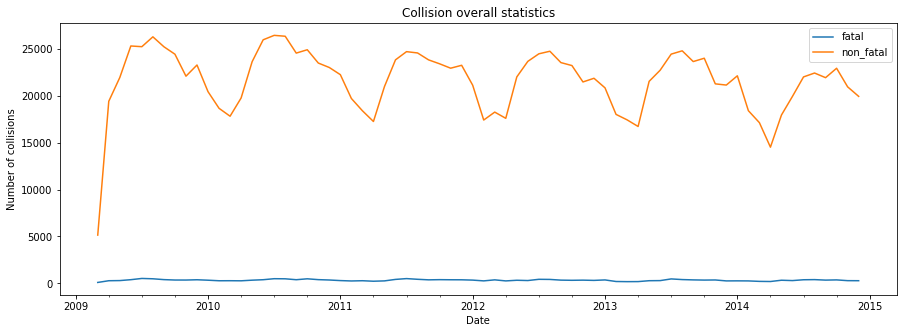

In [38]:
plot1=df_1.plot(figsize=(15,5),title='Collision overall statistics')
plot1.set_xlabel("Date")
plot1.set_ylabel("Number of collisions")

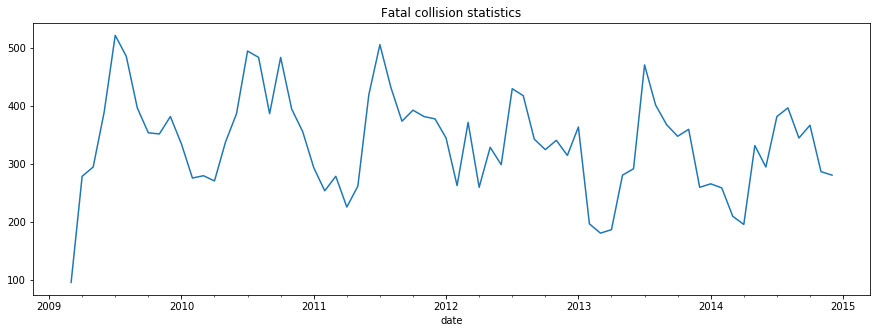

In [39]:
plot2=df_1['fatal'].plot(figsize=(15,5),title='Fatal collision statistics')

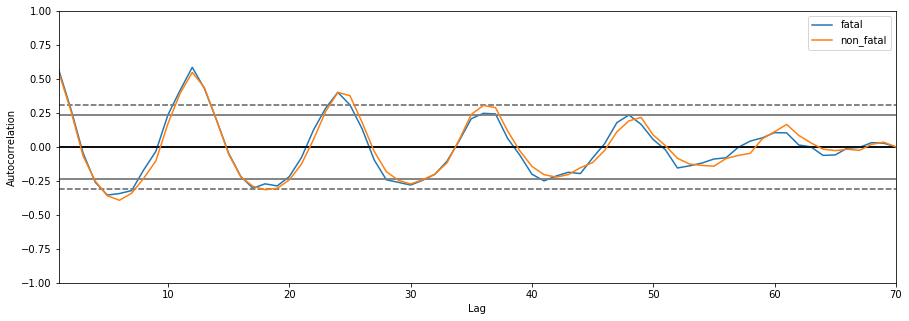

In [11]:
plt.figure(figsize=(15,5))
for c in df_1.columns:
    autocorrelation_plot(df_1[c],label=c)

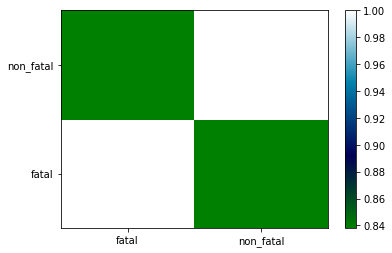

In [12]:
corr = df_1.corr()
pcolor(corr,cmap='ocean')
colorbar()
yticks([0.5,1.5],df_1.columns)
xticks([0.5,1.5],df_1.columns)

show()

In [13]:
#by_weekday = df.groupby('c_wday')['fatal','non_fatal'].sum()
by_weekday = df.groupby('c_wday')['c_sev'].count()
by_weekday
#by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
#by_weekday.plot(style=[':', '--', '-']);
#df_1=df.groupby('date')['fatal','non_fatal'].sum()

c_wday
1    203183
2    217931
3    221789
4    234158
5    259361
6    221987
7    179656
Name: c_sev, dtype: int64

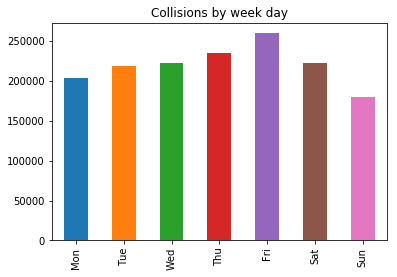

In [14]:
by_weekday = df.groupby('c_wday')['c_sev'].count()
by_weekday.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plot2 = by_weekday.plot(kind='bar',title='Collisions by week day')

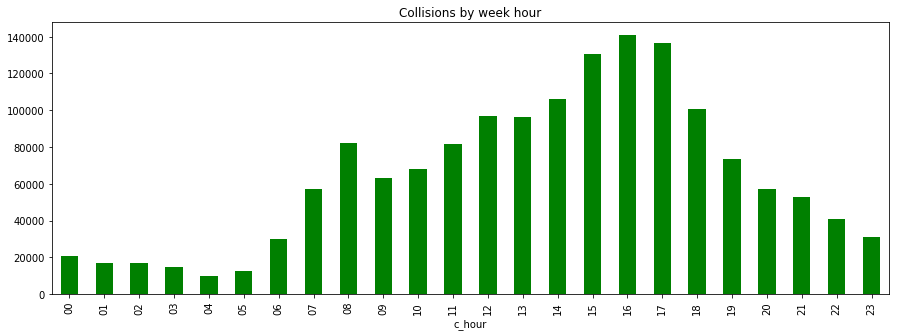

In [15]:
plt.figure(figsize=(15,5))
by_hour = df.groupby('c_hour')['c_sev'].count()
#by_weekday.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plot3 = by_hour.plot(kind='bar',title='Collisions by week hour',color='G')

In [32]:
df_2=df.groupby('c_rcfg')['c_sev'].count().sort_values(ascending=True)
df_2
#df_2.sort_values(ascending=False)

c_rcfg
10       255
07       270
09      1385
06      2060
08      3877
04      5782
05     14375
03     82614
01    613535
02    813912
Name: c_sev, dtype: int64

In [44]:
df_2.index=['Express lane of a freeway system','Passing or climbing lane','Traffic circle','Tunnel','Ramp',
            'Railroad level crossing','Bridge','Intersection with parking lot entrance/exit',
            'Non-intersection','At an intersection']

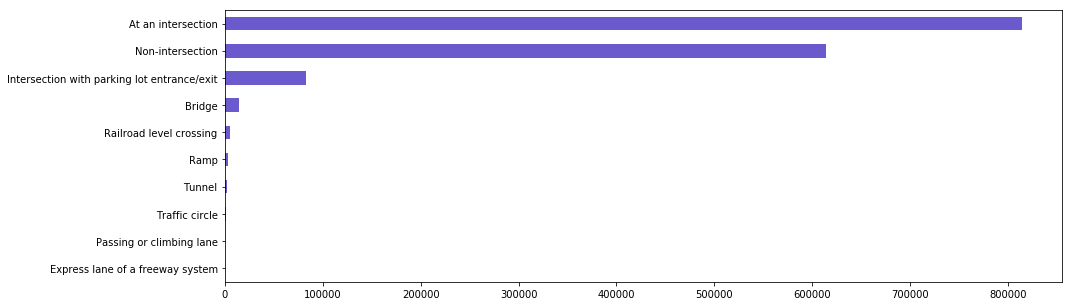

In [45]:
df_2.plot.barh(color='slateblue',figsize=(15,5))

In [40]:
df_3=df.groupby('c_wthr')['c_sev'].count().sort_values(ascending=True)
df_3

c_wthr
7       4020
5       6442
6      21591
4      77469
2     152493
3     166074
1    1109976
Name: c_sev, dtype: int64